In [172]:
%matplotlib widget
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [182]:
spy_tick = yf.Ticker('MSFT')

In [183]:
hist = spy_tick.history(start='2022-01-01', end='2023-01-01', interval="1h")
# spy_tick.history_metadata
# print(spy_tick.basic_info)
hist.head()
# print(type(hist.index[-1]- hist.index[0]))

# hist.index[-1]- hist.index[0] 
print(pd.Timedelta('20 days'))


20 days 00:00:00


Datetime
2022-01-03 09:30:00-05:00         NaN
2022-01-03 10:30:00-05:00    0.998316
2022-01-03 11:30:00-05:00    1.000274
2022-01-03 12:30:00-05:00    0.999312
2022-01-03 13:30:00-05:00    1.003545
                               ...   
2022-12-30 11:30:00-05:00    0.728279
2022-12-30 12:30:00-05:00    0.723552
2022-12-30 13:30:00-05:00    0.722039
2022-12-30 14:30:00-05:00    0.724649
2022-12-30 15:30:00-05:00    0.731577
Name: Close, Length: 1753, dtype: float64


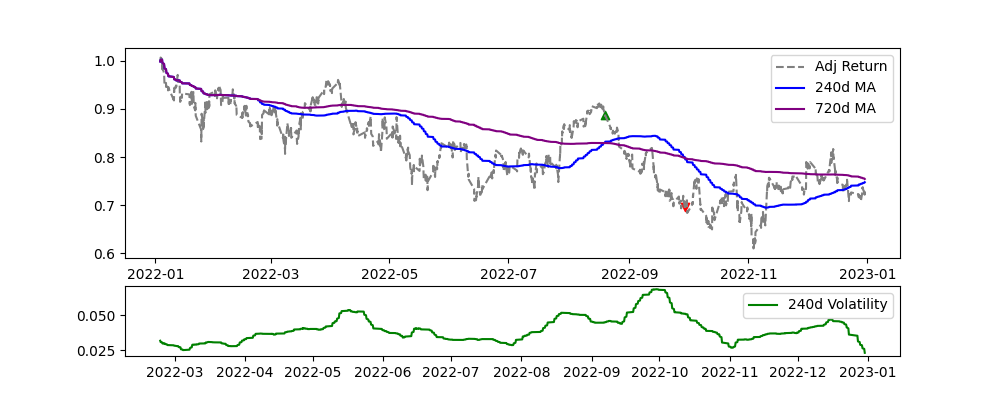

In [184]:
short_window = 240
long_window =  720

daily_pct_change = hist.Close/hist.Close.shift(1) -1
cum_daily_return = daily_pct_change.cumsum()+1
moving_avg_return = cum_daily_return.rolling(window=short_window, center=False, min_periods=1).mean()
moving_avg_return_60 = cum_daily_return.rolling(window=long_window, center=False, min_periods=1).mean()
print(cum_daily_return)
signal_df = pd.DataFrame(index=hist.index, columns=["Signal"])
signal_df["Signal"] = 0.0
signal_df["Short MAV"] = moving_avg_return
signal_df["Long MAV"] = moving_avg_return_60
signal_df["Signal"][short_window:][signal_df['Short MAV'][short_window:] > signal_df['Long MAV'][short_window:]] = 1
signal_df["Positions"] = signal_df["Signal"].diff()
# signal_df['Signal'][28:] = np.where(,1.0)

fig_return_and_vol, (ax_returns,ax_volatility) = plt.subplots(2,1, height_ratios=[3,1], figsize=(10,4))

ax_returns.plot(cum_daily_return, color='grey',ls='--', label='Adj Return')
ax_returns.plot(moving_avg_return, color='blue', label='{}d MA'.format(short_window))
ax_returns.plot(moving_avg_return_60, color='purple', label='{}d MA'.format(long_window))
for i in signal_df.index:
    if signal_df["Positions"][i] == 1:
        ax_returns.scatter(i,cum_daily_return[i],marker="^", color='green')
    if signal_df["Positions"][i] == -1:
        ax_returns.scatter(i, cum_daily_return[i], marker="v", color='red')

ax_returns.legend()
ax_volatility.plot(cum_daily_return.rolling(short_window).std(), color='green', label='{}d Volatility'.format(short_window))
# # ax_vol.plot(hist.Volume, color='blue')
plt.legend()
plt.show()


In [170]:
class backTestStrategy:
    def __init__(self, starting_funds, risk_tol, loss_tol, short, long, time_to_sell):
        self.init_cash = starting_funds
        self.wallet = starting_funds
        self.in_pos = False
        self.pos_size = risk_tol*starting_funds
        self.stock_held = 0.0
        self.loss_delta = risk_tol*starting_funds*loss_tol
        self.short_window = short
        self.long_window = long
        self.time_to_sell = pd.Timedelta(time_to_sell)
        self.reg_wallet = starting_funds
        self.reg_stock_held = 0.0

    def buy(self, price, day_idx):
        self.wallet -= self.pos_size
        self.last_bought_price = price
        self.day_bought = day_idx
        self.stock_held += self.pos_size/price
        self.in_pos = True
        print('Buy - {}'.format(day_idx))

    def sell(self, price, day_idx):
        self.wallet += price*self.stock_held
        self.in_pos = False
        self.stock_held = 0.0
        print('Sell - {}'.format(day_idx))

    def strategy(self, price_dataframe):
        current_price = price_dataframe['Close'][-1]
        if self.in_pos:
            if current_price <= self.last_bought_price - self.loss_delta:
                self.sell(current_price, price_dataframe.index[-1])
            elif (current_price > self.last_bought_price - self.loss_delta and current_price < self.last_bought_price + self.loss_delta and price_dataframe.index[-1] - self.day_bought > self.time_to_sell):
                self.sell(current_price, price_dataframe.index[-1])
            elif current_price > self.last_bought_price + self.loss_delta:
                self.buy(current_price, price_dataframe.index[-1])

        else:
            if price_dataframe['Close'][-short_window:].mean() > price_dataframe['Close'][-long_window:].mean():
                self.buy(current_price, price_dataframe.index[-1])

    def reg_invest(self, price_dataframe):
        current_price = price_dataframe['Close'][-1]
        if self.reg_wallet > self.pos_size:
            self.reg_stock_held += self.pos_size/current_price
            self.reg_wallet -= self.pos_size

    def run_strat(self, full_dataframe):
        val_print_ind = 0 
        for day in full_dataframe.index:
            print(day)
            self.strategy(full_dataframe[:day])
            if val_print_ind % 30 == 0:
                self.reg_invest(full_dataframe[:day])
            val_print_ind += 1


        if self.in_pos:
            final_pos_val = self.stock_held*full_dataframe['Close'][-1]
            print('Final Value: {}'.format(self.wallet+final_pos_val))
        else:
            print('Final wallet: {}'.format(self.wallet))

        b_n_h_val = self.init_cash*full_dataframe['Close'][-1]/full_dataframe['Close'][0]
        print('Buy and Hold wallet: {}'.format(b_n_h_val))

        print('Regular investor: {}'.format(self.reg_stock_held*full_dataframe['Close'][-1]+self.reg_wallet))


In [171]:
MomentumTest = backTestStrategy(1000, 0.05, 0.35, 28, 60, '2 days')
MomentumTest.run_strat(hist)
print(hist['Close'][-1]/hist['Close'][0])

2022-01-03 00:00:00-05:00
2022-01-04 00:00:00-05:00
2022-01-05 00:00:00-05:00
2022-01-06 00:00:00-05:00
2022-01-07 00:00:00-05:00
2022-01-10 00:00:00-05:00
2022-01-11 00:00:00-05:00
2022-01-12 00:00:00-05:00
2022-01-13 00:00:00-05:00
2022-01-14 00:00:00-05:00
2022-01-18 00:00:00-05:00
2022-01-19 00:00:00-05:00
2022-01-20 00:00:00-05:00
2022-01-21 00:00:00-05:00
2022-01-24 00:00:00-05:00
2022-01-25 00:00:00-05:00
2022-01-26 00:00:00-05:00
2022-01-27 00:00:00-05:00
2022-01-28 00:00:00-05:00
2022-01-31 00:00:00-05:00
Buy - 2022-01-31 00:00:00-05:00
Final Value: 1000.0
Buy and Hold wallet: 941.8058042380778
Regular investor: 997.090290211904
0.9418058042380778


In [99]:
print(hist["Close"][0])
print(hist["Close"][-1])

37.797142028808594
474.79998779296875


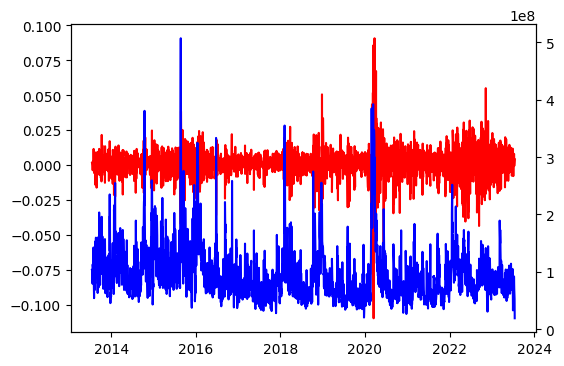

In [36]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
ax_vol = ax.twinx()
ax.plot(daily_pct_change, color='red')
ax_vol.plot(hist.Volume, color='blue')
plt.show()